<h1 style="color: #6cb4e4;  text-align: center;  padding: 0.25em;  border-top: solid 2.5px #6cb4e4;  border-bottom: solid 2.5px #6cb4e4;  background: -webkit-repeating-linear-gradient(-45deg, #f0f8ff, #f0f8ff 3px,#e9f4ff 3px, #e9f4ff 7px);  background: repeating-linear-gradient(-45deg, #f0f8ff, #f0f8ff 3px,#e9f4ff 3px, #e9f4ff 7px);height:45px;">
<b>
Only Submission(LoadLocalTrainModel)
</b></h1> 

### **ℹ️INFO**
* First of all, I'm grateful to the host for sharing such a great bass line.
* This notebook is an inference notebook that performed a unique LocalTrain based on the Train/Inference published by the host.
    * https://www.kaggle.com/code/andrewjdarley/train-yolo
    * https://www.kaggle.com/code/andrewjdarley/submission-notebook

---

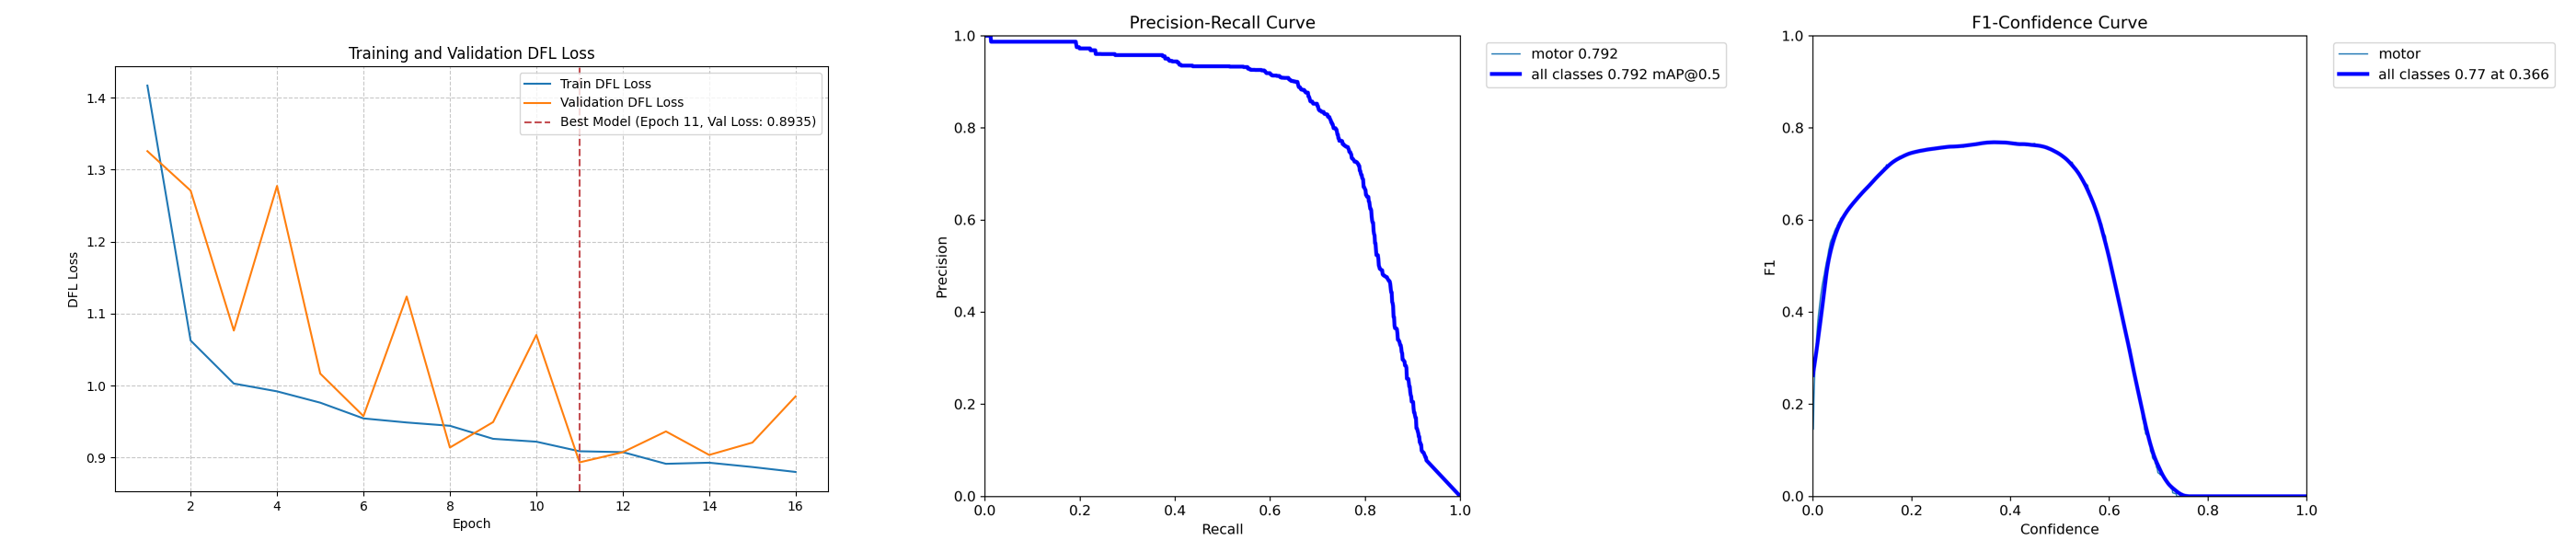

In [1]:
from PIL import Image
import os

pretrain_input = os.path.join('/kaggle/input', 'byu-yolov8n-nb001')

#TODO: Generate png
im1 = Image.open(os.path.join(pretrain_input,'F1_curve.png'))
im2 = Image.open(os.path.join(pretrain_input,'PR_curve.png'))
im3 = Image.open(os.path.join(pretrain_input,'dfl_loss_curve.png'))
def get_concat_h_multi_resize(im_list, resample=Image.BICUBIC):
    min_height = min(im.height for im in im_list)
    im_list_resize = [im.resize((int(im.width * min_height / im.height), min_height),resample=resample)
                      for im in im_list]
    total_width = sum(im.width for im in im_list_resize)
    dst = Image.new('RGB', (total_width, min_height))
    pos_x = 0
    for im in im_list_resize:
        dst.paste(im, (pos_x, 0))
        pos_x += im.width
    return dst
get_concat_h_multi_resize([im3, im2, im1])

<h1 style="color: #6cb4e4;  text-align: center;  padding: 0.25em;  border-top: solid 2.5px #6cb4e4;  border-bottom: solid 2.5px #6cb4e4;  background: -webkit-repeating-linear-gradient(-45deg, #f0f8ff, #f0f8ff 3px,#e9f4ff 3px, #e9f4ff 7px);  background: repeating-linear-gradient(-45deg, #f0f8ff, #f0f8ff 3px,#e9f4ff 3px, #e9f4ff 7px);height:45px;">
<b>
Inference Pipeline
</b></h1> 

## **》》》 [IMPORTANT] Env Params**

In [2]:
""" Train Model """
model_path = os.path.join(pretrain_input, 'best.pt')

""" [IMPORTANT]
* This parameter has a significant impact on the value of LB since it is the threshold for the prediction score inferred by the model.
* In my experiments, 0.5 to 0.55 is optimal for local CV, but when submitting, 0.35 to 0.45 seems to give better results, so there is a difference.
"""
CONFIDENCE_THRESHOLD = 0.40

MAX_DETECTIONS_PER_TOMO = 3
NMS_IOU_THRESHOLD = 0.2
CONCENTRATION = 1
BATCH_SIZE = 8 

## **》》》 Ultralytics Offline Install**(v8.3.88[2025/03/11 ReleaseVersion])

In [3]:
"""[INFO]
* This notebookinstall Ultralytics v8.3.88(2025/03/11 ReleaseVersion)
  Can use YOLO12 is latest family version. 
* If you need a newer version, you can make it available by running and attaching the notebook.
  https://www.kaggle.com/code/hideyukizushi/ultralytics-offlineinstall-yolo12-weights
"""
!tar xfvz /kaggle/input/ultralytics-offlineinstall-yolo12-weights/archive.tar.gz
!pip install --no-index --find-links=./packages ultralytics
!rm -rf ./packages

./packages/
./packages/pyparsing-3.2.1-py3-none-any.whl
./packages/tqdm-4.67.1-py3-none-any.whl
./packages/py_cpuinfo-9.0.0-py3-none-any.whl
./packages/matplotlib-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/requests-2.32.3-py3-none-any.whl
./packages/tzdata-2025.1-py2.py3-none-any.whl
./packages/nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/pytz-2025.1-py2.py3-none-any.whl
./packages/six-1.17.0-py2.py3-none-any.whl
./packages/psutil-7.0.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/ultralytics-8.3.88-py3-none-any.whl
./packages/MarkupSafe-3.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/triton-3.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/mpmath-1.3.0-py3-none-any.whl
./packages/PyYAML-6.0.2-cp310-cp310-manylinu

## **》》》 Import Libs**

In [4]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import cv2
from tqdm.notebook import tqdm
from ultralytics import YOLO
import threading
import time
from contextlib import nullcontext
from concurrent.futures import ThreadPoolExecutor

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **》》》 Seed Fix**

In [5]:
np.random.seed(42)
torch.manual_seed(42)

## **》》》 Inference&Submission**

* Dataset

In [6]:
data_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
test_dir = os.path.join(data_path, "test")
submission_path = "/kaggle/working/submission.csv"

* GPU Init

In [7]:
class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None
        
    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self
        
    def __exit__(self, *args):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.time() - self.start_time
        # print(f"[PROFILE] {self.name}: {elapsed:.3f}s")


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if device.startswith('cuda'):
    # Set CUDA optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs
    torch.backends.cudnn.allow_tf32 = True
    
    # Print GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")
    
    # Get available GPU memory and set batch size accordingly
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))  # 4 images per GB as rough estimate
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 4  # Reduce batch size for CPU

Using GPU: Tesla P100-PCIE-16GB with 17.06 GB memory
Dynamic batch size set to 32 based on 17.06GB free memory


* Inference

In [ ]:
def process_slice(slice_data:np.array, z, motor_pos:dict, patch_size:int=PATCH_SIZE, trust:int=TRUST):
    """
    Normalize slice data using the 2nd and 98th percentiles.
    In addition, apply padding to ensure a square image.
    The image is then split into patches of specified size.
    Each patch is checked for the presence of motors, and annotations are created accordingly.
    The annotations are stored in a dictionary with keys as patch indices.
    The function returns a dictionary containing the normalized image and annotations.
    The annotations are in the format: '0 x_center y_center width height/n'.
    The width and height are set to BOX_SIZE.

    Args:
        slice_data (numpy.array): Input image slice.
        motor_pos (dict): Dictionary containing motor positions. 
            example: {1:{'z_center': 100, 'x_center': 50, 'y_center': 50, 'voxel_spacing': 1},
                      2:{'z_center': 200, 'x_center': 150, 'y_center': 150, 'voxel_spacing': 1}}
        patch_size (int): Size of the patch to be extracted.

    Returns:
        results (dict): Dictionary containing the normalized image and annotations.
    """
    # Validate input
    if not isinstance(slice_data, np.ndarray):
        raise ValueError("slice_data must be a numpy array")
    if not isinstance(motor_pos, dict):
        raise ValueError("motor_pos must be a dictionary")
    if not isinstance(patch_size, int) or patch_size <= 0:
        raise ValueError("patch_size must be a positive integer")
    if not isinstance(trust, int) or trust < 0:
        raise ValueError("trust must be a non-negative integer")
    if not isinstance(z, int):
        raise ValueError("z must be an integer")
    # Pad the image to make it square
    h, w = slice_data.shape[:2]
    h_pad = patch_size - h%patch_size
    w_pad = patch_size - w%patch_size
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    mean = np.mean([p2, p98])
    if h_pad != 0:
        slice_data = np.pad(slice_data, ((0, h_pad), (0, 0)), mode='constant', constant_values=mean)
    if w_pad != 0:
        slice_data = np.pad(slice_data, ((0, 0), (0, w_pad)), mode='constant', constant_values=mean)
    
    clipped_data = np.clip(slice_data, p2, p98)
    normalized_image = 255 * (clipped_data - p2) / (p98 - p2)
    h, w = normalized_image.shape[:2]
    results = {}

    for i, tile_top in enumerate(range(0, h, patch_size)):
        for j, tile_left in enumerate(range(0, w, patch_size)):
            results[f'{i}_{j}'] = {'image':None, 'annotations':None}
            results[f'{i}_{j}']['image'] = normalized_image[tile_top:tile_top + patch_size, tile_left:tile_left + patch_size]
    return results

def preload_image_batch(file_paths):
    """Preload a batch of images to CPU memory"""
    images = []
    for path in file_paths:
        img = cv2.imread(path)
        if img is None:
            # Try with PIL as fallback
            img = np.array(Image.open(path))
        images.append(img)
    return images

def process_tomogram(tomo_id, model, index=0, total=1):
    """
    Process a single tomogram and return the most confident motor detection
    """
    # print(f"Processing tomogram {tomo_id} ({index}/{total})")
    
    # Get all slice files for this tomogram
    tomo_dir = os.path.join(test_dir, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    
    # Apply CONCENTRATION to reduce the number of slices processed
    # This will process approximately CONCENTRATION fraction of all slices
    selected_indices = np.linspace(0, len(slice_files)-1, int(len(slice_files) * CONCENTRATION))
    selected_indices = np.round(selected_indices).astype(int)
    slice_files = [slice_files[i] for i in selected_indices]
    

    all_detections = []
    if device.startswith('cuda'):
        streams = [torch.cuda.Stream() for _ in range(min(4, BATCH_SIZE))]
    else:
        streams = [None]
    
    # Variables for preloading
    next_batch_thread = None
    next_batch_images = None
    
    # Process slices in batches
    for batch_start in range(0, len(slice_files), BATCH_SIZE):
        # Wait for previous preload thread if it exists
        if next_batch_thread is not None:
            next_batch_thread.join()
            next_batch_images = None
            
        batch_end = min(batch_start + BATCH_SIZE, len(slice_files))
        batch_files = slice_files[batch_start:batch_end]
        
        # Start preloading next batch
        next_batch_start = batch_end
        next_batch_end = min(next_batch_start + BATCH_SIZE, len(slice_files))
        next_batch_files = slice_files[next_batch_start:next_batch_end] if next_batch_start < len(slice_files) else []
        
        if next_batch_files:
            next_batch_paths = [os.path.join(tomo_dir, f) for f in next_batch_files]
            next_batch_thread = threading.Thread(target=preload_image_batch, args=(next_batch_paths,))
            next_batch_thread.start()
        else:
            next_batch_thread = None
        
        # Split batch across streams for parallel processing
        sub_batches = np.array_split(batch_files, len(streams))
        sub_batch_results = []
        
        for i, sub_batch in enumerate(sub_batches):
            if len(sub_batch) == 0:
                continue
                
            stream = streams[i % len(streams)]
            with torch.cuda.stream(stream) if stream and device.startswith('cuda') else nullcontext():
                # Process sub-batch
                sub_batch_paths = [os.path.join(tomo_dir, slice_file) for slice_file in sub_batch]
                sub_batch_slice_nums = [int(slice_file.split('_')[1].split('.')[0]) for slice_file in sub_batch]
                
                # Run inference with profiling
                with GPUProfiler(f"Inference batch {i+1}/{len(sub_batches)}"):
                    sub_results = model(sub_batch_paths, verbose=False)
                
                # Process each result in this sub-batch
                for j, result in enumerate(sub_results):
                    if len(result.boxes) > 0:
                        boxes = result.boxes
                        for box_idx, confidence in enumerate(boxes.conf):
                            if confidence >= CONFIDENCE_THRESHOLD:
                                # Get bounding box coordinates
                                x1, y1, x2, y2 = boxes.xyxy[box_idx].cpu().numpy()
                                
                                # Calculate center coordinates
                                x_center = (x1 + x2) / 2
                                y_center = (y1 + y2) / 2
                                
                                # Store detection with 3D coordinates
                                all_detections.append({
                                    'z': round(sub_batch_slice_nums[j]),
                                    'y': round(y_center),
                                    'x': round(x_center),
                                    'confidence': float(confidence)
                                })
        
        # Synchronize streams
        if device.startswith('cuda'):
            torch.cuda.synchronize()
    
    # Clean up thread if still running
    if next_batch_thread is not None:
        next_batch_thread.join()
    
    # 3D Non-Maximum Suppression to merge nearby detections across slices
    final_detections = perform_3d_nms(all_detections, NMS_IOU_THRESHOLD)
    
    # Sort detections by confidence (highest first)
    final_detections.sort(key=lambda x: x['confidence'], reverse=True)
    
    # If there are no detections, return NA values
    if not final_detections:
        return {
            'tomo_id': tomo_id,
            'Motor axis 0': -1,
            'Motor axis 1': -1,
            'Motor axis 2': -1
        }
    
    # Take the detection with highest confidence
    best_detection = final_detections[0]
    
    # Return result with integer coordinates
    return {
        'tomo_id': tomo_id,
        'Motor axis 0': round(best_detection['z']),
        'Motor axis 1': round(best_detection['y']),
        'Motor axis 2': round(best_detection['x'])
    }

def perform_3d_nms(detections, iou_threshold):
    """
    Perform 3D Non-Maximum Suppression on detections to merge nearby motors
    """
    if not detections:
        return []
    
    # Sort by confidence (highest first)
    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    
    # List to store final detections after NMS
    final_detections = []
    
    # Define 3D distance function
    def distance_3d(d1, d2):
        return np.sqrt((d1['z'] - d2['z'])**2 + 
                       (d1['y'] - d2['y'])**2 + 
                       (d1['x'] - d2['x'])**2)
    
    # Maximum distance threshold (based on box size and slice gap)
    box_size = 24  # Same as annotation box size
    distance_threshold = box_size * iou_threshold
    
    # Process each detection
    while detections:
        # Take the detection with highest confidence
        best_detection = detections.pop(0)
        final_detections.append(best_detection)
        
        # Filter out detections that are too close to the best detection
        detections = [d for d in detections if distance_3d(d, best_detection) > distance_threshold]
    
    return final_detections

def debug_image_loading(tomo_id):
    """
    Debug function to check image loading
    """
    tomo_dir = os.path.join(test_dir, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    
    if not slice_files:
        print(f"No image files found in {tomo_dir}")
        return
        
    sample_file = slice_files[len(slice_files)//2]  # Middle slice
    img_path = os.path.join(tomo_dir, sample_file)
    
    # Try different loading methods
    try:
        # Method 1: PIL
        img_pil = Image.open(img_path)
        img_array_pil = np.array(img_pil)
        
        # Method 2: OpenCV
        img_cv2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # print(f"OpenCV Image shape: {img_cv2.shape}, dtype: {img_cv2.dtype}")
        
        # Method 3: Convert to RGB
        img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        
    # Also test with YOLO's built-in loader
    try:
        test_model = YOLO(model_path)
        test_results = test_model([img_path], verbose=False)
        # print("YOLO model successfully processed the test image")
    except Exception as e:
        print(f"Error with YOLO processing: {e}")

def generate_submission():
    """
    Main function to generate the submission file
    """
    test_tomos = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
    total_tomos = len(test_tomos)
    
    if test_tomos:
        debug_image_loading(test_tomos[0])
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    model = YOLO(model_path)
    model.to(device)
    
    # Additional optimizations for inference
    if device.startswith('cuda'):
        # Fuse conv and bn layers for faster inference
        model.fuse()
        
        # Enable model half precision (FP16) if on compatible GPU
        if torch.cuda.get_device_capability(0)[0] >= 7:  # Volta or newer
            model.model.half()
    
    # Process tomograms with parallelization
    results = []
    motors_found = 0

    with ThreadPoolExecutor(max_workers=1) as executor:
        future_to_tomo = {}
        
        # Submit all tomograms for processing
        for i, tomo_id in enumerate(test_tomos, 1):
            future = executor.submit(process_tomogram, tomo_id, model, i, total_tomos)
            future_to_tomo[future] = tomo_id
        
        # Process completed futures as they complete
        for future in future_to_tomo:
            tomo_id = future_to_tomo[future]
            try:
                # Clear CUDA cache between tomograms
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
                result = future.result()
                results.append(result)
                
                # Update motors found count
                has_motor = not pd.isna(result['Motor axis 0'])
                if has_motor:
                    motors_found += 1
                    print(f"Motor found in {tomo_id} at position: "
                          f"z={result['Motor axis 0']}, y={result['Motor axis 1']}, x={result['Motor axis 2']}")
                else:
                    print(f"No motor detected in {tomo_id}")
                    
                print(f"Current detection rate: {motors_found}/{len(results)} ({motors_found/len(results)*100:.1f}%)")
            
            except Exception as e:
                print(f"Error processing {tomo_id}: {e}")
                # Create a default entry for failed tomograms
                results.append({
                    'tomo_id': tomo_id,
                    'Motor axis 0': -1,
                    'Motor axis 1': -1,
                    'Motor axis 2': -1
                })
    
    # Create submission dataframe
    submission_df = pd.DataFrame(results)
    
    # Ensure proper column order
    submission_df = submission_df[['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
    
    # Save the submission file
    submission_df.to_csv(submission_path, index=False)
    print("="*50)
    print("= Submission preview:")
    print("="*50)
    print(submission_df.head())
    
    return submission_df

# Run the submission pipeline
if __name__ == "__main__":
    # Time entire process
    start_time = time.time()
    
    # Generate submission
    submission = generate_submission()
    
    # Print total execution time
    elapsed = time.time() - start_time
    print(f"\nTotal execution time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
Motor found in tomo_003acc at position: z=-1, y=-1, x=-1
Current detection rate: 1/1 (100.0%)
Motor found in tomo_00e047 at position: z=165, y=546, x=604
Current detection rate: 2/2 (100.0%)
Motor found in tomo_01a877 at position: z=142, y=642, x=285
Current detection rate: 3/3 (100.0%)
= Submission preview:
       tomo_id  Motor axis 0  Motor axis 1  Motor axis 2
0  tomo_003acc            -1            -1            -1
1  tomo_00e047           165           546           604
2  tomo_01a877           142           642           285

Total execution time: 49.02 seconds (0.82 minutes)
